In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn import discriminant_analysis
from imblearn.under_sampling import CondensedNearestNeighbour

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids 

from sklearn.multioutput import MultiOutputClassifier

from sklearn.ensemble import ExtraTreesClassifier

from sklearn.decomposition import PCA, NMF
from sklearn.datasets import load_digits

from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix, hstack, vstack

from time import time
from pprint import pprint
import pickle

import re
from itertools import compress
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.utils.extmath import density
from sklearn.utils import resample
from collections import Counter

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

from sklearn.base import BaseEstimator

In [2]:
path = './input/'
#path = '../input/'
data = pd.read_csv(path+'train.csv')
submission_input = pd.read_csv(path+'test.csv')
print('Number of rows and columns in the train data set:',data.shape)
print('Number of rows and columns in the test data set:',submission_input.shape)

('Number of rows and columns in the train data set:', (159571, 8))
('Number of rows and columns in the test data set:', (153164, 2))


In [3]:
target_col = data.columns.values[range(2,8)]

In [4]:
targets = data.iloc[:,range(2,8)]

In [5]:
toxic_comment_data = data.loc[(targets==1).any(axis=1),:]

In [55]:
class multi_labels_LogisticRegression:
   
    def __init__(self,penalty='l2', dual=False, tol=1e-4, C=1.0,
                 fit_intercept=True, intercept_scaling=1, class_weight=None,
                 random_state=None, solver='liblinear', max_iter=100,
                 multi_class='ovr', verbose=0, warm_start=False, n_jobs=1,
                min_df = 2, max_df = 0.95, n_gram = 4, n_features = 2000,
                resampling = True, top_features = 1000,
                all_comments = False,
                num_class = 1, train_test_ratio = 0.8,
                analyzers = ['char','word'],
                fs = 'tree_50',
                estimator = 'nn',
                resampling_method = 'random',
                preprocess = True,
                fs_before_resampling = True):
        
        self.penalty = penalty
        self.dual = dual
        self.tol = tol
        self.C = C
        self.fit_intercept = fit_intercept
        self.intercept_scaling = intercept_scaling
        self.class_weight = class_weight
        self.random_state = random_state
        self.solver = solver
        self.max_iter = max_iter
        self.multi_class = multi_class
        self.verbose = verbose
        self.warm_start = warm_start
        self.n_jobs = n_jobs
        
        #self.word_vectorizer = []
        self.list_LogisticRegression = []
        self.list_label = []
        
        #Probability predictions of Training and Testing
        self.y_train_true = []
        self.y_train_scores = []
        self.y_test_true = []
        self.y_test_scores = []
        
        self.word_vectorizers = []
        #self.word_vectorizer_w = []
        self.path = './input/' 
        self.target_col = []
        self.list_topWord_Index = []
        self.train_test_ratio = train_test_ratio
        
        #Score of Training and Testing
        self.train_score = []
        self.test_score = []
        
        #Model training scorer
        self.train_scorer_ = []
        self.results = []
        
        # Word matrix conversion factors
        self.min_df = min_df
        self.max_df = max_df
        self.n_gram = n_gram
        self.n_features = n_features
        self.analyzers = analyzers
        
        self.resampling = resampling
        self.resampling_method = resampling_method
        self.top_features = top_features
        
        self.all_comments = all_comments
        self.num_class = num_class
        
        self.fs = fs
        self.estimator = estimator
        
        self.preprocess = preprocess
        self.fs_before_resampling = fs_before_resampling
        
    
    # Transforming comments list into word frequency matrix
    #def data_transform(self, comments_list, vectorizers_list = self.word_vectorizers):
    #    word_data_list = []
    #    for i,word_vector in enumerate(vectorizers_list):
    #        word_data_list = word_data_list + [word_vector.transform(comments_list)]
    #    
    #    return sparse.hstack(word_data_list)
    
    def data_transform(self, comments_list):
        word_data_list = []
        for i,word_vector in enumerate(self.word_vectorizers):
            word_data_list = word_data_list + [word_vector.transform(comments_list)]
        
        return sparse.hstack(word_data_list)
    
    # Using Forest Trees to select top words
    def features_selection(self, X,y):
        
        t0 = time()
        if 'tree' in self.fs:
            n = np.int(self.fs.split('_')[1])
            print("Processing features selection by %d Forest Trees:..." %n)

            forest = ExtraTreesClassifier(n_estimators=n,
                                  random_state=0, n_jobs=-1)

            forest.fit(X,y)

            #nb = MultinomialNB()
            #nb.fit(X,y)

            importances = forest.feature_importances_
            std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                         axis=0)
            indices = np.argsort(importances)[::-1]
            index_ = indices[range(self.top_features)]
            
        elif self.fs == 'sv':
            svc = SVC(kernel="linear")
            print("Processing features selection by Kernel:...")
            # The "accuracy" scoring is proportional to the number of correct
            # classifications
            rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
                          scoring='accuracy', n_jobs=-1)
            rfecv.fit(X, y)

            print("Optimal number of features : %d" % rfecv.n_features_)

            # Plot number of features VS. cross-validation scores
            plt.figure()
            plt.xlabel("Number of features selected")
            plt.ylabel("Cross validation score (nb of correct classifications)")
            plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
            plt.show()

            index_ = rfecv.support_
            print("Number of features selected by SV: %d" %index_.sum())
            
        elif 'chi' in self.fs:
            n = np.int(self.fs.split('_')[1])
            print("Processing features selection by Chi2, k = %d:..." %n)
            ch2 = SelectKBest(chi2, k= n)
            X_train = ch2.fit_transform(X, y)
            
            index_ = ch2.get_support(indices=False)
            print("Number of features selected by Chi2: %d" %index_.sum())
            print(index_)
        else:
            index_ =  np.array([True]*X.shape[1])
        
        train_time = time() - t0
        print("&" * 80)
        print("Features Selection time: %0.3fs" % train_time)
        
        return index_
    
    # Resampling unbalanced dataset
    def under_resampling_func(self, X, y):
        t0 = time()
        print("Processing Resampling...")
        
        if 'random' in self.resampling_method:
            rus = RandomUnderSampler(random_state=1)
        else:
            rus = ClusterCentroids(random_state=1, n_jobs=-1)
        
        X_res, y_res = rus.fit_sample(X, y)

        train_time = time() - t0
        print("Resampling time: %0.3fs" % train_time)
            
        return X_res, y_res
    
    # Extracting dataset per "Target" class
    def train_test_target_split(self, data, toxic_class, fraction = 0.8):
        # Extracting data per "toxic_class"
        is_toxic = data[data[toxic_class]==1]
        no_toxic = data[~data.index.isin(is_toxic.index)]

        # Shuffling the data before taking samples
        is_toxic = shuffle(is_toxic)
        no_toxic = shuffle(no_toxic)

        ### Splitting data into Training and Testing

        # Toxic data
        training_toxic = is_toxic.sample(frac=fraction)
        testing_toxic = is_toxic.loc[~is_toxic.index.isin(training_toxic.index)]

        # Non-toxic data
        training_no_toxic = no_toxic.sample(frac=fraction)
        testing_no_toxic = no_toxic.loc[~no_toxic.index.isin(training_no_toxic.index)]

        # Training and Testing datasets
        data_training = shuffle(pd.concat([training_toxic, training_no_toxic], axis = 0))
        data_testing = shuffle(pd.concat([testing_toxic, testing_no_toxic], axis = 0))

        # Training and Testing 'comment_text' preditor, and target for "toxic" class
        y_training_toxic = data_training[toxic_class]
        y_testing_toxic = data_testing[toxic_class]

        X_training_comment = data_training['comment_text']
        X_testing_comment = data_testing['comment_text']
        
        # Generating Word_Vector for Training and Testing data
        #print("Extracting features from the training data using a sparse vectorizer for class: %s" %toxic_class)
        X_train = self.data_transform(X_training_comment)
        #print("n_samples: %d, n_features: %d" % X_train.shape)

        #print("Extracting features from the test data using the same vectorizer for class: %s" %toxic_class)
        X_test = self.data_transform(X_testing_comment)
        #print("n_samples: %d, n_features: %d" % X_test.shape)

        # ***** Targets of Training and Testing datasets
        y_train, y_test = y_training_toxic, y_testing_toxic

        return {'X_train':X_train, 'y_train':y_train ,'X_test':X_test, 'y_test': y_test}
    
    # Transforming Comment dataset into Words matrix dataset
    def words_matrix_convert(self, X, y):
        
        # Generating Word_Vector for Training and Testing data
        print("Converting Comments dataset to Words Matrix")
        X_ = self.data_transform(X)
        print("n_samples: %d, n_features: %d" % X_.shape)

        return X_, y
    
    def build_word_vectors(self, data):
        t0 = time()
        word_vectorizers = []
        for analyzer in self.analyzers:    
            print("Building words vector from the comments of the training data using a sparse vectorizer %s" % analyzer)
            word_vectorizer = TfidfVectorizer(min_df = self.min_df, max_df = self.max_df, lowercase=True, analyzer=analyzer,
                            stop_words= 'english',ngram_range=(1,self.n_gram),max_features=self.n_features)
            
            if self.all_comments:
                # Building word vector on the whole dataset
                word_vector = word_vectorizer.fit_transform(data['comment_text'])#(data['comment_text'])
            else:
                targets = data.iloc[:,range(2,8)]
                # Building word vector basing on Toxic comments only:
                word_vector = word_vectorizer.fit_transform(data.loc[(targets==1).any(axis=1),:]['comment_text'])
             
            word_vectorizers = word_vectorizers + [word_vectorizer]

        train_time = time() - t0
        print("Word Matrix training time: %0.3fs" % train_time)
        
        return word_vectorizers
    
    # Probability prediction
    def toxic_predict(self, comments_list):
        
        if self.word_vectorizers == []:
            print('The models are not yet trained!')
        else:
            X = self.data_transform(comments_list)
        
            y_pred = []
            for i,col in enumerate(self.target_col):
                
                if self.top_features > 0:
                    X_ = X.tocsc()[:,self.list_topWord_Index[i]]
                else:
                    X_ = X
               
                p = np.round(self.list_LogisticRegression[i].predict_proba(X_)[:,1],3)
                y_pred = y_pred + [p]

        return np.transpose(y_pred)
    
    def feature_selection_func(self, X_train, y_train, X_test, y_test):
        if self.top_features > 0: 
            topWord_Index = self.features_selection(X_train, y_train)
            self.list_topWord_Index = self.list_topWord_Index + [topWord_Index]
            
            X_train_, y_train_ = X_train.tocsc()[:,topWord_Index], y_train
            print("Feature reduced X, n_samples: %d, n_features: %d" % X_train_.shape)
            
            X_test_, y_test_ = X_test.tocsc()[:,topWord_Index], y_test
        else:
            X_train_, y_train_, X_test_, y_test_ = X_train, y_train, X_test, y_test
        
        return X_train_, y_train_, X_test_, y_test_
    
    def preprocess_function(self, X_train, y_train, X_test, y_test, fs_before_resampling = True):
        
        if fs_before_resampling:
            X_train_, y_train_, X_test_, y_test_ = self.feature_selection_func(X_train, y_train, X_test, y_test)
            if self.resampling: 
                X_train_, y_train_ = self.under_resampling_func(X_train_, y_train_)
                print("Resampled X_train, n_samples: %d, n_features: %d" % X_train_.shape)    
            else:
                print("No resampling...")
        else:
            if self.resampling:
                X_train_, y_train_ = self.under_resampling_func(X_train, y_train)
                print("Resampled X_train, n_samples: %d, n_features: %d" % X_train_.shape)
            else:
                print("No resampling...")   
            X_train_, y_train_, X_test_, y_test_ = self.feature_selection_func(X_train_, y_train_, X_test, y_test)
            
        return X_train_, y_train_, X_test_, y_test_
    
    def training_LogisticRegression(self, X_train, y_train, X_test, y_test): 
                                    #preprocess = True, fs_before_resampling = True):#, scores = ['recall']): #'precision']
       
        #### feature selection BEFORE RESAMPLING:
        #if self.top_features > 0:
            
        #    topWord_Index = self.features_selection(X_train, y_train)
        #    self.list_topWord_Index = self.list_topWord_Index + [topWord_Index]

            # Reducing Features
        #    X_train, y_train = X_train.tocsc()[:,topWord_Index], y_train
        #    print("Feature reduced X_train, n_samples: %d, n_features: %d" % X_train.shape)

        #    X_test, y_test = X_test.tocsc()[:,topWord_Index], y_test
        #    print("Feature reduced X_test, n_samples: %d, n_features: %d" % X_test.shape)
        
        
        #if self.resampling:
        #   X_train, y_train = self.under_resampling_func(X_train, y_train)
        #    print("Resampled X_train, n_samples: %d, n_features: %d" % X_train.shape)
        #else:
            #X_train, y_train = X_train, y_train
        #    print("No resampling...")
        
        
        #### feature selection AFTER RESAMPLING:
        
        
        
        
        #######

        t0 = time()
        #for score in scores:
        #print("# Tuning hyper-parameters for %s" % score)
        print("******** Beginning Training Process: %s *********" %self.estimator)
        #sv = GridSearchCV(SVC(), tuned_parameters, cv=5, scoring='%s_macro' % score)
        scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
        
        if 'lr' in self.estimator:
            ######Fitting Logistic Regression *********************
            param_grid = {'C': [10, 20, 50, 100, 200, 500, 1000] }

            sv = GridSearchCV(LogisticRegression(intercept_scaling=1,
                        dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
                              param_grid = param_grid, n_jobs=-1, scoring=scoring, cv=10, refit='AUC')#, scoring='%s_macro' % score) # cv=5,
        
        elif 'sv' in self.estimator:
            #### Fitting SVM*******************
            parameters = {
                'alpha': (0.00001, 0.000001),
                'penalty': ('l2', 'elasticnet'),
                'n_iter': (10, 50, 80),
            }
            sv = GridSearchCV(SGDClassifier(),
                               n_jobs=-1, param_grid = parameters, scoring=scoring, cv=10, refit='AUC')
        
        else:
            #self.estimator == 'nn':
            #####Fitting CNN********************
            params = {'hidden_layer_sizes': [(50,),(100,),(200,) ,(50,50,),(100,50,)]}
            #params = {'hidden_layer_sizes': [(100,)],
            #         'solver': ('lbfgs', 'adam')}
            mlp = MLPClassifier()
            sv = GridSearchCV(mlp, param_grid = params, verbose=10, n_jobs=-1, cv=5, scoring=scoring, refit='AUC')#
        
        sv.fit(X_train, y_train)
        
        train_time = time() - t0
        print("********* TRAINING Time: %0.3fs" % train_time)

        print("Best parameters set found on development set:")
        print()
        print(sv.best_params_)
        print()
        

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true_test_sv, y_pred_test_sv = y_test, sv.predict(X_test)
        print(classification_report(y_true_test_sv, y_pred_test_sv))
        print()
        print("Confusion matrix:")
        print(metrics.confusion_matrix(y_true_test_sv, y_pred_test_sv))
            
        return sv, X_train, y_train, X_test, y_test
    
    # Fitting the models
    def fit(self, data):
        
        if self.word_vectorizers == []:
            self.word_vectorizers = self.build_word_vectors(data)
        
        self.target_col = data.columns.values[2:2+self.num_class]
        
        for i,col in enumerate(self.target_col):
            print('Building {} model for toxic class:{''}'.format(i,col)) 
    
            model_input = self.train_test_target_split(data, col, fraction = self.train_test_ratio)

            X_train, y_train  = model_input['X_train'], model_input['y_train'] 
            X_test, y_test = model_input['X_test'], model_input['y_test']
            
            print("FOR TRAINING - X_train, n_samples: %d, n_features: %d" % X_train.shape)
            print("FOR TESTING: X_test, n_samples: %d, n_features: %d" % X_test.shape)
            
            if self.preprocess:
                X_train, y_train, X_test, y_test = self.preprocess_function(X_train, y_train, 
                                                                            X_test, y_test, 
                                                                            self.fs_before_resampling)

            sv, X_train, y_train, X_test, y_test = self.training_LogisticRegression(X_train, y_train, X_test, y_test)

            self.list_label = self.list_label + [col]
            self.list_LogisticRegression = self.list_LogisticRegression + [sv]
            
            self.y_train_true = self.y_train_true + [y_train]
            self.y_train_scores = self.y_train_scores + [sv.predict_proba(X_train)]
            
            self.y_test_true = self.y_test_true + [y_test]
            self.y_test_scores = self.y_test_scores + [sv.predict_proba(X_test)]
            
            self.train_score = self.train_score + [sv.score(X_train, y_train)]
            self.test_score = self.test_score + [sv.score(X_test, y_test)]
            
            if self.estimator != 'nn':
                self.train_scorer_ = self.train_scorer_ + [sv.scorer_]
                self.results = self.results + [sv.cv_results_]

            print('=' * 80)
            
    def print_roc_curve(self):
        
        for i,col in enumerate(self.target_col):
            fpr_test, tpr_test, _ = roc_curve(self.y_test_true[i], self.y_test_scores[i][:,1])
            fpr_train, tpr_train, _ = roc_curve(self.y_train_true[i], self.y_train_scores[i][:,1])

            roc_auc_test = auc(fpr_test, tpr_test)
            roc_auc_train = auc(fpr_train, tpr_train)

            plt.figure()
            lw = 2
            plt.plot(fpr_test, tpr_test, color='darkorange',
                     lw=lw, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
            plt.plot(fpr_train, tpr_train, color='blue',
                     lw=lw, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC curve for toxic comment of label: {''}' .format(col))
            plt.legend(loc="lower right")
            plt.show()
    
    def print_grid_search(self):
        scoring, results = self.list_LogisticRegression[0].scorer_, self.list_LogisticRegression[0].cv_results_
        
        plt.figure(figsize=(13, 13))
        plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
                  fontsize=16)

        plt.xlabel("C param")
        plt.ylabel("Score")
        plt.grid()

        ax = plt.axes()
        ax.set_xlim(0, 402)
        ax.set_ylim(0.73, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_C'].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['g', 'k']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        plt.legend(loc="best")
        plt.grid('off')
        plt.show()
        
    def submission_output(self, submission_input):
        Y_submit_pred = pd.DataFrame(self.toxic_predict(submission_input['comment_text']))
        Y_submit_pred.columns = np.array(self.target_col)
        submission_output = pd.concat([submission_input['id'], Y_submit_pred],axis=1)

        return submission_output
    
    def to_submission_file(self, submission_output, filename = 'submission.csv'):
        submission_output.to_csv(self.path+filename, index=False)

In [ ]:
#range(1), num_class = 1
submission_data = []
list_LR = []
for i in range(1):
    print("Training Process %s: " %i)
    print("%"*80)
    multi_labels_LR = multi_labels_LogisticRegression(min_df = 2, max_df = 0.95, n_gram = 5, n_features = 10000,
                resampling = True, top_features = 5000,
                all_comments = False,
                num_class = 1, analyzers = ['char', 'word'], estimator = 'lr', fs = 'tree_25')
    multi_labels_LR.fit(data)
    submission_data = submission_data + [multi_labels_LR.submission_output(submission_input)]
    list_LR = list_LR + [multi_labels_LR]

In [ ]:
df_concat = pd.concat(submission_data)
by_row_index = df_concat.groupby([df_concat.index, df_concat.id])
df_means = by_row_index.mean()
df_means = df_means.reset_index('id')

df_means.to_csv(path+'submission.csv', index=False)

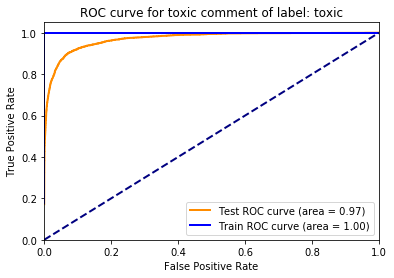

In [58]:
for i in range(1):
    list_LR[i].print_roc_curve()

In [7]:
multi_labels_LR = multi_labels_LogisticRegression(min_df = 2, max_df = 0.95, n_gram = 5, n_features = 10000,
                resampling = True, top_features = 5000,
                all_comments = False,
                num_class = 1, analyzers = ['char', 'word'], estimator = 'lr', fs = 'tree_25')

In [9]:
multi_labels_LR.word_vectorizers = multi_labels_LR.build_word_vectors(data)

Building words vector from the comments of the training data using a sparse vectorizer char
Building words vector from the comments of the training data using a sparse vectorizer word
Word Matrix training time: 35.667s


In [29]:
vectorizers = multi_labels_LR.word_vectorizers

In [10]:
model_input = multi_labels_LR.train_test_target_split(data, 'toxic', fraction = 0.8)

In [39]:
X_train_, y_train_  = model_input['X_train'], model_input['y_train'] 
X_test_, y_test_ = model_input['X_test'], model_input['y_test']

In [18]:
X, y = multi_labels_LR.under_resampling_func(X_train, y_train)

Processing Resampling...
Resampling time: 8.423s


In [40]:
y_train_scores = list()
y_test_scores = list()

#Score of Training and Testing
train_score = list()
test_score = list()

train_scorer = list()
results = list()

In [41]:
list_top_features = [1000, 2000, 3000, 4000, 5000]
list_fs = ['tree_25', 'tree_50', 'tree_100', 'tree_200']
#list(itertools.product(list_top_features, list_fs)

In [42]:
import itertools

In [ ]:
for top_features_i, fs_i in list(itertools.product(list_top_features, list_fs)):
    multi_labels_LR = multi_labels_LogisticRegression(min_df = 2, max_df = 0.95, n_gram = 5, n_features = 10000,
                resampling = True, top_features = top_features_i,
                all_comments = False,
                num_class = 1, analyzers = ['char', 'word'], estimator = 'lr', fs = fs_i)
    
    multi_labels_LR.word_vectorizers = vectorizers
    
    sv, X_train, y_train, X_test, y_test = multi_labels_LR.training_LogisticRegression(X_train_, y_train_, 
                                                                                       X_test_, y_test_)
    
    y_train_scores.append(sv.predict_proba(X_train))
    y_test_scores.append(sv.predict_proba(X_test))

    #Score of Training and Testing
    train_score.append(sv.score(X_train, y_train))
    test_score.append(sv.score(X_test, y_test))

    train_scorer.append(sv.scorer_)
    results.append(sv.cv_results_)

Processing features selection by 25 Forest Trees:...
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
Features Selection time: 95.446s
Feature reduced X_train, n_samples: 127657, n_features: 1000
Feature reduced X_test, n_samples: 31914, n_features: 1000
Processing Resampling...
Resampling time: 0.332s
Resampled X_train, n_samples: 24470, n_features: 1000
******** Beginning Training Process: lr *********
********* TRAINING Time: 83.289s
Best parameters set found on development set:
()
{'C': 50}
()
Detailed classification report:
()
The model is trained on the full development set.
The scores are computed on the full evaluation set.
()
             precision    recall  f1-score   support

          0       0.99      0.93      0.96     28855
          1       0.59      0.89      0.71      3059

avg / total       0.95      0.93      0.94     31914

()
Confusion matrix:
[[26957  1898]
 [  350  2709]]
Processing features selection by 50 Forest Trees:...
&&&&&

             precision    recall  f1-score   support

          0       0.99      0.94      0.96     28855
          1       0.60      0.90      0.72      3059

avg / total       0.95      0.93      0.94     31914

()
Confusion matrix:
[[27000  1855]
 [  315  2744]]
Processing features selection by 50 Forest Trees:...
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
Features Selection time: 180.631s
Feature reduced X_train, n_samples: 127657, n_features: 3000
Feature reduced X_test, n_samples: 31914, n_features: 3000
Processing Resampling...
Resampling time: 0.625s
Resampled X_train, n_samples: 24470, n_features: 3000
******** Beginning Training Process: lr *********
********* TRAINING Time: 244.063s
Best parameters set found on development set:
()
{'C': 20}
()
Detailed classification report:
()
The model is trained on the full development set.
The scores are computed on the full evaluation set.
()
             precision    recall  f1-score   support

  

********* TRAINING Time: 291.038s
Best parameters set found on development set:
()
{'C': 10}
()
Detailed classification report:
()
The model is trained on the full development set.
The scores are computed on the full evaluation set.
()
             precision    recall  f1-score   support

          0       0.99      0.93      0.96     28855
          1       0.59      0.90      0.72      3059

avg / total       0.95      0.93      0.94     31914

()
Confusion matrix:
[[26970  1885]
 [  295  2764]]
Processing features selection by 100 Forest Trees:...
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
Features Selection time: 322.035s
Feature reduced X_train, n_samples: 127657, n_features: 5000
Feature reduced X_test, n_samples: 31914, n_features: 5000
Processing Resampling...
Resampling time: 0.778s
Resampled X_train, n_samples: 24470, n_features: 5000
******** Beginning Training Process: lr *********
********* TRAINING Time: 310.396s
Best parameters set f

In [49]:
vectorizers

[TfidfVectorizer(analyzer='char', binary=False, decode_error=u'strict',
         dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
         lowercase=True, max_df=0.95, max_features=10000, min_df=2,
         ngram_range=(1, 5), norm=u'l2', preprocessor=None, smooth_idf=True,
         stop_words='english', strip_accents=None, sublinear_tf=False,
         token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None),
 TfidfVectorizer(analyzer='word', binary=False, decode_error=u'strict',
         dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
         lowercase=True, max_df=0.95, max_features=10000, min_df=2,
         ngram_range=(1, 5), norm=u'l2', preprocessor=None, smooth_idf=True,
         stop_words='english', strip_accents=None, sublinear_tf=False,
         token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None)]

In [52]:
len(multi_labels_LR.list_topWord_Index[0])

5000

In [53]:
LR = multi_labels_LogisticRegression(min_df = 2, max_df = 0.95, n_gram = 5, n_features = 10000,
                resampling = True, top_features = 1000,
                all_comments = False,
                num_class = 1, analyzers = ['char', 'word'], estimator = 'lr', fs = 'tree_25')

In [56]:
LR.fit(data)

Building words vector from the comments of the training data using a sparse vectorizer char
Building words vector from the comments of the training data using a sparse vectorizer word
Word Matrix training time: 38.118s
Building 0 model for toxic class:toxic
FOR TRAINING - X_train, n_samples: 127657, n_features: 20000
FOR TESTING: X_test, n_samples: 31914, n_features: 20000
Processing features selection by 25 Forest Trees:...
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
Features Selection time: 86.129s
Feature reduced X_train, n_samples: 127657, n_features: 1000
Feature reduced X_test, n_samples: 31914, n_features: 1000
Processing Resampling...
Resampling time: 0.416s
Resampled X_train, n_samples: 24470, n_features: 1000
******** Beginning Training Process: lr *********
********* TRAINING Time: 82.845s
Best parameters set found on development set:
()
{'C': 50}
()
Detailed classification report:
()
The model is trained on the full development set.
The 

In [57]:
LR.word_vectorizers

[TfidfVectorizer(analyzer='char', binary=False, decode_error=u'strict',
         dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
         lowercase=True, max_df=0.95, max_features=10000, min_df=2,
         ngram_range=(1, 5), norm=u'l2', preprocessor=None, smooth_idf=True,
         stop_words='english', strip_accents=None, sublinear_tf=False,
         token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None),
 TfidfVectorizer(analyzer='word', binary=False, decode_error=u'strict',
         dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
         lowercase=True, max_df=0.95, max_features=10000, min_df=2,
         ngram_range=(1, 5), norm=u'l2', preprocessor=None, smooth_idf=True,
         stop_words='english', strip_accents=None, sublinear_tf=False,
         token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None)]

In [60]:
len(LR.list_topWord_Index[0])

1000

In [ ]:
list(itertools.product(list_top_features, list_fs))

In [ ]:
y_train_scores
y_test_scores

In [ ]:
#Score of Training and Testing
train_score

In [ ]:
test_score 

In [ ]:
train_scorer
results

In [20]:
from sklearn import svm, datasets, feature_selection
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [21]:
transform = feature_selection.SelectPercentile(feature_selection.f_classif)

In [22]:
clf = Pipeline([('anova', transform), ('svc', svm.SVC(C=1.0))])

In [23]:
clf

Pipeline(memory=None,
     steps=[('anova', SelectPercentile(percentile=10,
         score_func=<function f_classif at 0x1163e5758>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [ ]:
# #############################################################################
# Create a feature-selection transform and an instance of SVM that we
# combine together to have an full-blown estimator

transform = feature_selection.SelectPercentile(feature_selection.f_classif)

clf = Pipeline([('anova', transform), ('svc', svm.SVC(C=1.0))])

# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, X, y, n_jobs=-1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title(
    'Performance of the SVM-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')

plt.axis('tight')
plt.show()

In [ ]:
for i in range(1):
    list_LR[i].print_grid_search()

In [115]:
list_LR[0].train_score, list_LR[0].test_score

([0.98965589583769298], [0.95883572929974348])

In [116]:
list_LR[1].train_score, list_LR[1].test_score

([0.97321538813278785], [0.9629558950074969])

In [16]:
list_LR[0].train_scorer_

[{'AUC': make_scorer(roc_auc_score, needs_threshold=True),
  'Accuracy': make_scorer(accuracy_score)}]

In [17]:
list_LR[0].list_LogisticRegression[0].best_params_

{'C': 100}

In [91]:
list_LR[0].list_LogisticRegression[0].scorer_

{'AUC': make_scorer(roc_auc_score, needs_threshold=True),
 'Accuracy': make_scorer(accuracy_score)}

In [18]:
scoring = list_LR[0].list_LogisticRegression[0].scorer_

In [19]:
results = list_LR[0].list_LogisticRegression[0].cv_results_

In [20]:
results['param_C'].data

array([1, 10, 20, 50, 100, 200], dtype=object)

In [21]:
scoring

{'AUC': make_scorer(roc_auc_score, needs_threshold=True),
 'Accuracy': make_scorer(accuracy_score)}

In [22]:
results['mean_train_AUC']

/Users/huytran/anaconda3/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_AUC'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


array([ 0.95092942,  0.96764489,  0.97028474,  0.97265538,  0.97380379,
        0.97455556])

In [23]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

/Users/huytran/anaconda3/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_AUC'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/huytran/anaconda3/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_Accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/huytran/anaconda3/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_Accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_ar

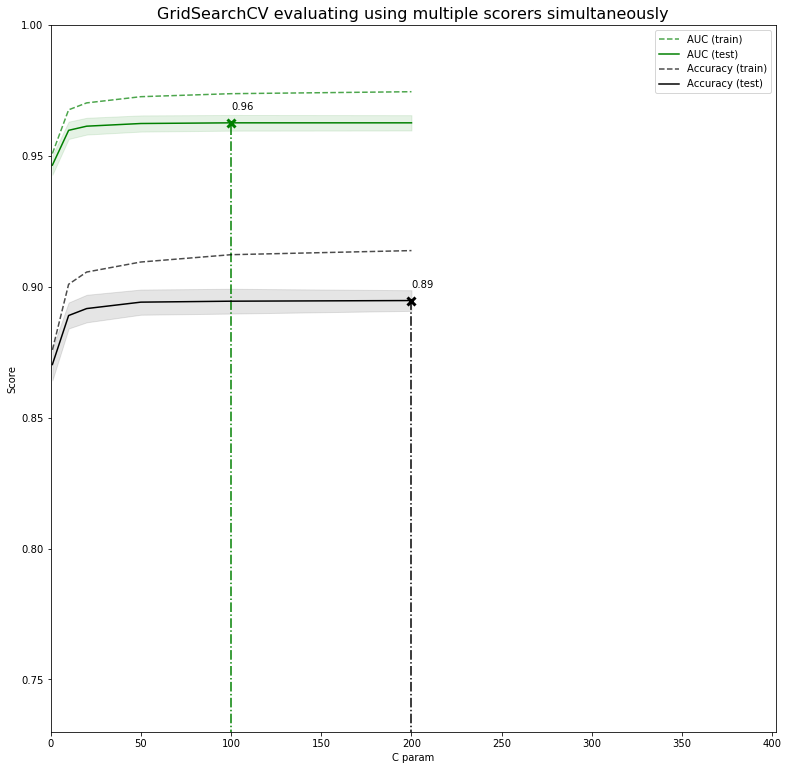

In [24]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("C param")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()